In [1]:
#import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# import libraries for EDA and preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# import libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# import libraries for evaluating
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linhtran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linhtran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We have BBC News Train and BBC News Test data downloaded from Kaggle which consists of 5 categories in total. And the goal is to assign one category to a news article in test data. The five categories we want to identify are Sports, Business, Politics, Tech, and Entertainment.

To do this, we will train two models:   
(1) an unsupervised model using matrix factorization  
(2) multiple supervised model such as SVM, KNN, Random Forest.    
These models are built to have their testing accuracy and then I will compare these models for their performance.

## Step 1: Inspect, Visualize and Clean the Data

In [2]:
# read data
train_df = pd.read_csv('BBC News Train.csv')


In [3]:
# read data
test_df = pd.read_csv('BBC News Test.csv')


In [4]:
# take a look at some rows of train data
train_df.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
# the shape of train data
train_df.shape


(1490, 3)

In [6]:
# get a quick description of the data
train_df.describe()


,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [7]:
# the structure of data also tells us the number of rows (observations) and columns (variables)
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
# get the category of train data
train_df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [9]:
# check null values in train data
train_df.isnull().sum()


ArticleId    0
Text         0
Category     0
dtype: int64

In [10]:
# check for duplicate articles
train_df.duplicated(keep=False).sum()


0

From the output above, we can summarize that:  
+ There are 1490 rows and 3 columns in train data.
+ There are five categories in train data, include 'business', 'tech', 'politics', 'sport' and 'entertainment'.
+ There is no missing values.
+ There is one integer column and it is Article ID.
+ There are two object columns, they are Text and Category.
+ There is no duplicate articles.  
Next, I will calculate and visualize the count and the proportion of each label in train data.

In [11]:
# calculate the count of each label
train_df['Category'].value_counts()


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [12]:
# calculate the proportion of each label
train_df['Category'].value_counts()/len(train_df)*100


sport            23.221477
business         22.550336
politics         18.389262
entertainment    18.322148
tech             17.516779
Name: Category, dtype: float64

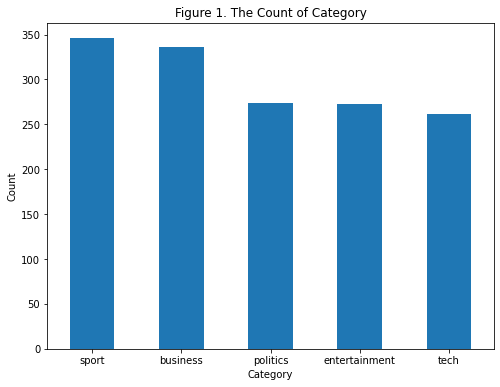

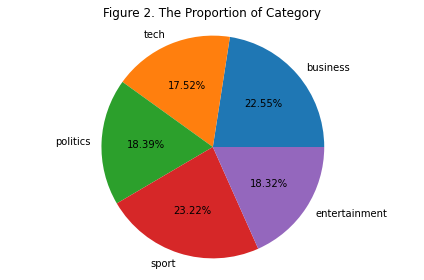

In [13]:
# plot the count of each category
fig, ax = plt.subplots(figsize=(8,6))
train_df['Category'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel("Category")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 1. The Count of Category")

# plot the proportion of each category
labels = train_df['Category'].unique().tolist()
counts = train_df['Category'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("Figure 2. The Proportion of Category")

plt.tight_layout()
plt.show()


Looking at Figure 2, we can see the proportions of each kind of article. In overall, the number of article for each category is not different too much. I think this is good since if one or two categories was severely underrepresentated or, in contrast, overrepresentative in the train data, then it may cause our model to be biased and/or perform poorly on some or all of the test data.

To preprocess our text simply means to bring our text into a form that is predictable and analyzable for our task. So, what I am going to do is:      
    (1) lowercasing all our text data    
    (2) remove punctuation    
    (3) remove stop words: stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead.  
    (4) lemmatization: lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.
    
Because I will redo these cleaning steps for test data as well, thus for convenience, I will create a clean_text function for train data and reuse it for cleaning test data later.

In [14]:
def clean_text(data, text):
    # lowercasing all text data
    data[text] = data[text].str.lower()
    # remove punctuation
    data[text] = data[text].str.replace('[^\w\s]', '', regex=True)
    # remove stop words
    stop_words = stopwords.words('english')
    data[text] = data[text].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    data[text] = data[text].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return


In [15]:
# clean train data
clean_text(train_df, "Text")

# view text in the first row after cleaning all text data
train_df["Text"][0]


'worldcom exboss launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted director irregular accounting practice u telecom giant 2002 warning led collapse firm following discovery 11bn 57bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial ch

In [16]:
# calculate the count of word per article
train_df["Word_Count"] = train_df['Text'].apply(lambda x: len(x.split()))


In [17]:
# view some first rows of train data
train_df.head()


,ArticleId,Text,Category,Word_Count
0,1833,worldcom exboss launch defence lawyer defendin...,business,191
1,154,german business confidence slide german busine...,business,203
2,1101,bbc poll indicates economic gloom citizen majo...,business,292
3,1976,lifestyle governs mobile choice faster better ...,tech,353
4,917,enron boss 168m payout eighteen former enron d...,business,211


In [18]:
# The average count of word per article
np.mean(train_df.Word_Count)


219.6469798657718

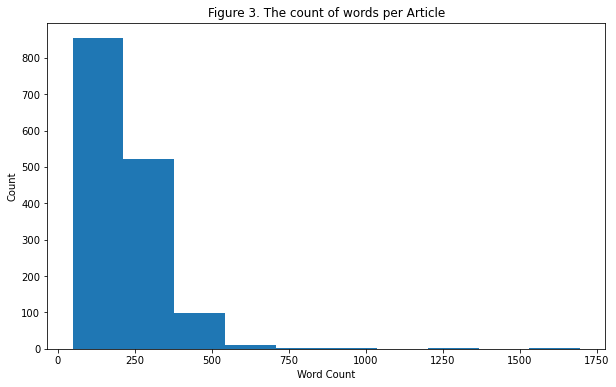

In [19]:
# plot the count of word per article
fig, ax = plt.subplots(figsize=(10,6))
train_df['Word_Count'].plot(kind='hist')
plt.xlabel("Word Count")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Figure 3. The count of words per Article")
plt.show()


We see that the average count of words per article is about 220 and looking at Figure 3, there are some outliers that have over 750 word count per article. Thus, I would like to remove articles that have more than 750 words. And then I will plot the count of words per category.

In [20]:
# remove outliers have more than 750 words
train_df = train_df[train_df.Word_Count <= 750]
len(train_df)


1484

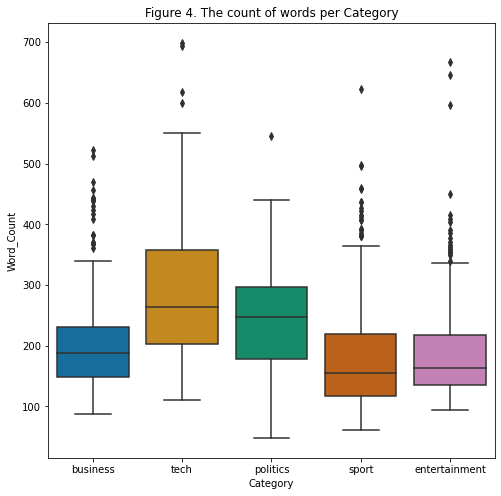

In [21]:
# visualize the count of words per category
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data = train_df, x = 'Category', y = 'Word_Count', palette = 'colorblind'
           ).set(title = 'Figure 4. The count of words per Category')
plt.show()


Looking at Figure 4, we observe that the mean of word count of each category is not different much, tech and politics have more words and variance than business, sport and entertainment.

#### Split data

After cleaning, to prepare for building and training models, we split 20% of the data into a separate cross validation dataset, keeping the same proportion of classes in each subset.

In [22]:
# split the data into train and crossval
train_df = train_df.drop(columns='Word_Count')
train, crossval = train_test_split(train_df, test_size=0.2, random_state = 42)
print('Training set:')
train. head()


Training set:


,ArticleId,Text,Category
384,674,msps hear renewed climate warning climate chan...,politics
536,286,nissan name successor ghosn nissan named lifet...,business
678,581,napster offer rented music go music downloadin...,tech
486,2021,ad sale boost time warner profit quarterly pro...,business
408,1483,youssou n dour win music prize senegalese musi...,entertainment


In [23]:
# get shape of train dataset after splitting
train.shape

(1187, 3)

In [24]:
print('Cross validation set:')
crossval.head()


Cross validation set:


,ArticleId,Text,Category
124,1091,smart search let art fan browse know art know ...,tech
435,2175,lifestyle governs mobile choice faster better ...,tech
1037,856,japan bank share link talk share sumitomo mits...,business
533,1468,commodore find new lease life oncefamous commo...,tech
1423,7,blair prepares name poll date tony blair likel...,politics


In [25]:
# get shape of cross validation dataset after splitting
crossval.shape


(297, 3)

## Step 2: Building and training models

Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers (vectors) so as the algorithms will be able make predictions.

Different approaches exist to convert text into the corresponding numerical form. In this case I will use the Term Frequency — Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents. Note that we are passing a number of parameters to this work:
    
+ min_df is used for removing terms that appear too infrequently, set to 0.002 means "ignore terms that appear in less than 0.2% of the documents". This is to avoid rare words, which drastically increase the size of our features and might cause overfitting.      
+ max_df is used for removing terms that appear too frequently, set to 0.95 means "ignore terms that appear in more than 95% of the documents".    
+ norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1. This is helpful for visualizing these vectors, and can also improve (or deteriorate) the performance of some models.   
+ ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams, or in other terms: we want to consider single words ("prices", "player") and pairs of words ("stock prices", "football player").   
+ stop_words is set to "english" to remove all common pronouns ("a", "the", ...) and further reduce the number of noisy features.   
+ sublinear_df is set to True to use a logarithmic form for frequency, to give diminishing returns as the frequency of a word increases.   


In [26]:
# use IFIDF to convert words into numerical features
vectorizer = TfidfVectorizer(min_df=0.002, max_df=0.95, norm='l2', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)
X = vectorizer.fit_transform(train.Text)
    

In [27]:
# Get a feel of the features identified by tfidf
X.toarray()


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04042066, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03212369, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.03232147, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03519229, ..., 0.        , 0.        ,
        0.        ]])

In [28]:
# get the shape of the features
X.shape


(1187, 15020)

Next, I'll build Non-Negative Matrix Factorization (NMF) model.  First, I'm just passing a number of parameters to this model by default, except for n_components=5, because we have 5 topics.

In [29]:
#create model
nmf_model = NMF(n_components=5, 
                init=None, 
                solver = 'cd',
                beta_loss = 'frobenius',
                random_state = 42)

# fit and transform the model to TF-IDF:
W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [30]:
# features dimension
W.shape

(1187, 5)

In [31]:
# components dimension
H.shape

(5, 15020)

In [32]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(H, columns=vectorizer.get_feature_names())
components_df

,00,00 draw,000,000 amicus,000 balloted,000 barrel,000 business,000 car,000 complaint,000 copy,...,zero tolerance,zhang,zimbabwe,ziyi,ziyi zhang,zombie,zone,zoom,zurich,zurich premiership
0,0.000000,0.000515,0.127216,0.000000,0.000000,0.000000,0.000893,0.001538,0.006656,0.004646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.017592,0.006198,0.017319,0.000000,0.000000
1,0.014613,0.008882,0.017295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000313,0.000000,...,0.004520,0.000000,0.007543,0.000000,0.000000,0.000000,0.007335,0.000000,0.010289,0.010751
2,0.001530,0.000000,0.066593,0.003640,0.003640,0.000000,0.003314,0.000000,0.000785,0.000000,...,0.007903,0.000000,0.001757,0.000000,0.000000,0.000000,0.001702,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.036131,0.000000,0.000000,0.000000,0.000000,0.000000,0.002122,0.008509,...,0.000000,0.026069,0.001553,0.019936,0.019936,0.003006,0.001654,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.080791,0.000157,0.000157,0.010749,0.002367,0.011482,0.000939,0.000923,...,0.000000,0.000000,0.001556,0.000000,0.000000,0.000000,0.009115,0.000000,0.004595,0.000000


We have created the 5 topics using NMF. Let’s have a look at the 10 more important words for each topic.


In [33]:
# get 10 more important words for each topic
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
people        0.345764
user          0.311274
technology    0.302175
phone         0.272005
mobile        0.268877
digital       0.263531
service       0.259729
computer      0.252358
music         0.247690
software      0.246573
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
game        0.347778
win         0.259950
player      0.255049
england     0.248411
match       0.243483
cup         0.217961
champion    0.210155
play        0.208086
injury      0.203786
team        0.202624
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
mr                0.353970
labour            0.343664
election          0.335550
party             0.296008
blair             0.287186
minister          0.267165
tory              0.266430
government        0.258987
prime minister    0.205558
prime             0.205421
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
film        

In [34]:
# create predict function
def predict(W):
    sortedW = np.argsort(W)
    n_prediction, maxValue = sortedW.shape
    prediction = [[sortedW[i][maxValue - 1]] for i in range(n_prediction)]
    topic = np.empty(n_prediction, dtype = np.int64)
    for i in range(n_prediction):
        topic[i] = prediction[i][0]
    return topic


In [35]:
# create label permuation compare
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    p = list(itertools.permutations(list(range(n))))
    label_ls = list(ytdf['Category'].unique())
    acc_score = []
    for i in range(len(p)):
        map_dict = dict(zip(label_ls, list(p[i])))
        yt = ytdf['Category'].apply(lambda x:map_dict[x])
        acc_score.append(accuracy_score(yt, yp))
    index = np.argmax(acc_score)
    return p[index], acc_score[index]


In [36]:
# predict, show best labels for the train model and calculate accuracy
yhat_train = predict(W)
label_order, accuracy = label_permute_compare(train, yhat_train)
print('\nLabel order for training set based on NMF: ', label_order)
print('\nAccuracy for training set based on NMF: {:.3f}%'.format(accuracy*100))



Label order for training set based on NMF:  (2, 4, 0, 3, 1)

Accuracy for training set based on NMF: 94.861%


In [37]:
# Check confusion matrix
mapdict = dict(zip(list(train["Category"].unique()), label_order))
yt = train["Category"].apply(lambda x: mapdict[x])
print('\nConfusion matrix for training set based on NMF: ')
confusion_matrix(yt, yhat_train)


Confusion matrix for training set based on NMF: 


array([[192,   6,   2,   3,   5],
       [  0, 264,   1,   2,   2],
       [  3,   0, 206,   0,   9],
       [ 10,   2,   1, 204,   8],
       [  2,   0,   5,   0, 260]])

In [38]:
# predict, show best labels for the cross validatiion model and calculate accuracy
X_cross = vectorizer.fit_transform(crossval.Text)
W_cross = nmf_model.fit_transform(X_cross)
yhat_cross = predict(W_cross)
label_order_cross, accuracy_cross = label_permute_compare(crossval, yhat_cross)
print('\nLabel order for cross validation set based on NMF: ', label_order_cross)
print('\nAccuracy for cross validation set based on NMF: {:.3f}%'.format(accuracy_cross*100))



Label order for cross validation set based on NMF:  (3, 0, 1, 2, 4)

Accuracy for cross validation set based on NMF: 66.330%


In [39]:
# Check confusion matrix
mapdict_cross = dict(zip(list(crossval["Category"].unique()), label_order_cross))
yt_cross = crossval["Category"].apply(lambda x: mapdict_cross[x])
print('\nConfusion matrix for cross validation set based on NMF: ')
confusion_matrix(yt_cross, yhat_cross)



Confusion matrix for cross validation set based on NMF: 


array([[68,  0,  1,  0,  0],
       [ 2, 49,  1,  0,  2],
       [ 0,  0, 75,  0,  0],
       [47,  0,  0,  5,  0],
       [22,  3, 17,  5,  0]])

#### Improve NMF  model

Choosing the parameters for NMF model by default, we got a low accuracy score for the train and cross validation set. Because embeddings are the "computational representation" of our data, the representation of a word in the vector space is defined by its surroundings, the words that it commonly goes along with. Therefore, to create embeddings, the larger the corpus, the better, since it can better place a word vector in the vector space and hence compare it to other similar words. To improve the accuracy score, I'll not splitting the data, use the entire dataset, to obtain a more wholesome word embedding representation. And then I'll programmatically evaluate which init, solver and beta_loss metric lead to the best performance and use this best model to predict on the test data.

In [40]:
# use IFIDF to convert words into numerical features
vectorizer = TfidfVectorizer(min_df=0.002, max_df=0.95, norm='l2', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)
X_df = vectorizer.fit_transform(train_df.Text)

In [41]:
#create model
nmf_model = NMF(n_components=5, 
                init=None, 
                solver = 'cd',
                beta_loss = 'frobenius',
                random_state = 42)

# fit and transform the model to TF-IDF:
W_df = nmf_model.fit_transform(X_df)

In [42]:
# predict, show best labels for the train model and calculate accuracy
yhat_train_df = predict(W_df)
label_order_df, accuracy_df = label_permute_compare(train_df, yhat_train_df)
print('\nLabel order for training set based on NMF: ', label_order_df)
print('\nAccuracy for entire dataset based on NMF: {:.3f}%'.format(accuracy_df*100))



Label order for training set based on NMF:  (4, 0, 2, 1, 3)

Accuracy for entire dataset based on NMF: 95.620%


As the result above, we can see that the accuracy score when using entire dataset is higher than when splitting the data. Next, I'll programmatically evaluate which init, solver and beta_loss metric lead to the best performance and use this best model to predict on the test data.

In [43]:
# programmatically evaluate which init, solver and beta_loss metric lead to the best performance
dic = {"time":0, "init":"", "solver": "", "beta_loss":"", "labelorder":[], "acc":0}
df = pd.DataFrame(dic)
for init in ["random", "nndsvda", "nndsvdar", "custom"]:
    for beta_loss in ["frobenius", "kullback-leibler", "itakura-saito"]:
        for solver in ["cd", "mu"]:
            acc = 0
            t0 = time.time()
            try:
                model = NMF(n_components=5, init=init, solver = solver, beta_loss=beta_loss, random_state = 42)
                yhat_train_df = predict(model.fit_transform(X_df))
                label_order, acc = label_permute_compare(train_df, yhat_train_df)
                t1 = time.time()
                df.loc[len(df.index)] = [t1-t0, init, solver, beta_loss, label_order, acc]
              
            except:
                print(init, "with", beta_loss, "with", solver, "not allowed.")
df = df.sort_values(by='acc', ascending = False)
display(df)


random with kullback-leibler with cd not allowed.
random with itakura-saito with cd not allowed.
random with itakura-saito with mu not allowed.
nndsvda with kullback-leibler with cd not allowed.
nndsvda with itakura-saito with cd not allowed.
nndsvda with itakura-saito with mu not allowed.
nndsvdar with kullback-leibler with cd not allowed.
nndsvdar with itakura-saito with cd not allowed.
nndsvdar with itakura-saito with mu not allowed.
custom with frobenius with cd not allowed.
custom with frobenius with mu not allowed.
custom with kullback-leibler with cd not allowed.
custom with kullback-leibler with mu not allowed.
custom with itakura-saito with cd not allowed.
custom with itakura-saito with mu not allowed.


,time,init,solver,beta_loss,labelorder,acc
5,3.217015,nndsvda,mu,kullback-leibler,"(4, 0, 2, 1, 3)",0.964286
8,3.619843,nndsvdar,mu,kullback-leibler,"(4, 0, 2, 1, 3)",0.962264
1,0.321175,random,mu,frobenius,"(0, 3, 4, 1, 2)",0.960916
3,0.267021,nndsvda,cd,frobenius,"(4, 0, 2, 1, 3)",0.956873
6,0.270493,nndsvdar,cd,frobenius,"(4, 0, 2, 1, 3)",0.956873
4,0.286090,nndsvda,mu,frobenius,"(4, 0, 2, 1, 3)",0.951482
7,0.338082,nndsvdar,mu,frobenius,"(4, 0, 2, 1, 3)",0.950135
0,0.199140,random,cd,frobenius,"(3, 4, 0, 1, 2)",0.942722
2,6.042528,random,mu,kullback-leibler,"(4, 2, 3, 1, 0)",0.629380


In [44]:
# show the best model
best_model = NMF(n_components=5, init="nndsvda", solver = "mu", beta_loss="kullback-leibler", random_state = 42)

# use best model for predicting training set
yhat_train_df = predict(best_model.fit_transform(X_df))
label_order_df, acc_df = label_permute_compare(train_df, yhat_train_df)
mapdict_df = dict(zip(list(train_df["Category"].unique()), label_order_df))
print('\nLabel order for entire dataset based on best NMF: ', mapdict_df)
print('\nAccuracy for training set based on best NMF: {:.3f}%'.format(acc_df*100))

# Check confusion matrix
#mapdict_df = dict(zip(list(train_df["Category"].unique()), label_order_df))
yt_df = train_df["Category"].apply(lambda x: mapdict_df[x])
print('\nConfusion matrix for training set based on best NMF: ')
confusion_matrix(yt_df, yhat_train_df)


Label order for entire dataset based on best NMF:  {'business': 4, 'tech': 0, 'politics': 2, 'sport': 1, 'entertainment': 3}

Accuracy for training set based on best NMF: 96.429%

Confusion matrix for training set based on best NMF: 


array([[254,   0,   0,   5,   1],
       [  1, 333,  10,   0,   0],
       [  1,   0, 268,   1,   2],
       [  7,   0,   2, 262,   1],
       [ 16,   0,   5,   1, 314]])

#### Use best model to predict test data

After finding the best model for our data, now we will test this model on the test set and print out the result. Again, before predicting, we need to repeat the same steps to clean the test data like we did in the train data.

In [45]:
# take a look at some rows of test data
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [46]:
# clean test data
clean_text(test_df, "Text")

# view text in the first row after cleaning all text data
test_df["Text"][0]

'qpr keeper day head preston queen park ranger keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi r manager ian holloway said might say risk recalled month simon royce recalled charlton iron fire yes couple others need day ranger contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davy either permanently loan saturday match ipswich davy impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty'

In [47]:
# use IFIDF to convert words into numerical features
Y = vectorizer.fit_transform(test_df.Text)

# predict test data
yhat_test = predict(best_model.fit_transform(Y))

#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category'])
test_predictions['ArticleId'] = test_df['ArticleId']
test_predictions['yhat'] = yhat_test
n_mapdict = dict(zip(label_order_df, list(train_df["Category"].unique())))
test_predictions['Category'] = test_predictions['yhat'].apply(lambda x: n_mapdict[x])

#delete columns unneeded for submission
test_predictions = test_predictions.drop(columns='yhat')

# view some first rows of the result
test_predictions.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,entertainment
4,1020,sport


## Step 3: Compare with supervised learning

Since our train data has the categories, we can use supervised models to solve the category of each BBC News article. That is, we look for a classifier that can take a word embedding as an input and predict a text class. To keep things simple, we will use the same preprocessing and word embedding produced by TfidfVectorizer with the same hyperparameters and use RandomForest to train model.  

With RandomForest, I use oob_score to evaluate the prediction. The out-of-bag (OOB) error is the average error for each  calculated using predictions from the trees that do not contain  in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated while being trained. And I'll do hyperparameter tuning for Random Forest using GridSearchCV and fit the data.  

I'll also build some other supervised models such as SVM and KNN and use cross validation score to compare with NMF and the best Random Forest.

#### Random Forest

In [48]:
# build RandomForest model
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=100, oob_score=True)
classifier_rf.fit(X_df, train_df.Category)

# checking the oob score
classifier_rf.oob_score_


0.8564690026954178

#### Improve Random Forest model

In [49]:
# Let’s do hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_df, train_df.Category)


Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [50]:
# get the best score
rf_best_score = grid_search.best_score_
print("\nRandom Forest best score: {:.3f}%".format(rf_best_score*100))

# best model
rf_best = grid_search.best_estimator_
print("\nRandom Forest best model:", rf_best)


Random Forest best score: 94.744%

Random Forest best model: RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


After finding the best Random Forest model, now I would like to run some other models as well and compare them.

In [52]:
# build SVM, KNN models and compare with NMF and best Random Forest model
models = {"SVM": SVC(), "KNN": KNeighborsClassifier(n_neighbors=5),
          "Random Forest": RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)}
dic = {"model": "", "acc":0}
df = pd.DataFrame([dic])
for model_name, model in models.items():
    acc = cross_val_score(model, X_df, train_df.Category, cv = 5)
    df.loc[len(df.index)] = [model_name, round(np.mean(acc)*100,3)]
df.loc[len(df.index)] = ['NMF', 96.429] 
df = df.sort_values(by='acc', ascending = False)
display(df)         


,model,acc
1,SVM,97.372
4,NMF,96.429
2,KNN,96.361
3,Random Forest,94.947
0,,0.000


#### Conclusion

From the result above, we can see that unsupervised learning gives a better model with higher accuracy (96.429%) compare with supervised learning Random Forest (94.947%) and KNN, however it has lower accuracy compare with SVM model (97.372%)

###  Effect of the data size on supervised Random Forest model and unsupervised NMF model 

I'm using Learning Curve to determine cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

In [53]:
from sklearn.model_selection import learning_curve

In [54]:
# learning_curve for Random Forest
Xtrain_full = vectorizer.fit_transform(train_df.Text)
ytrain_full = train_df.Category
print('Learning curve for Random Forest model\n')
rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200, n_jobs=-1, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(rf_model, Xtrain_full, ytrain_full, verbose=3)
    

Learning curve for Random Forest model

[learning_curve] Training set sizes: [ 118  385  652  919 1187]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................., score=(train=0.636, test=0.387) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ..................., score=(train=0.974, test=0.906) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ..................., score=(train=0.974, test=0.939) total time=   0.4s
[CV] END ..................., score=(train=0.971, test=0.943) total time=   0.5s
[CV] END ..................., score=(train=0.974, test=0.953) total time=   0.7s
[CV] END ..................., score=(train=0.788, test=0.593) total time=   0.2s
[CV] END ..................., score=(train=0.979, test=0.889) total time=   0.3s
[CV] END ..................., score=(train=0.985, test=0.919) total time=   0.4s
[CV] END ..................., score=(train=0.985, test=0.912) total time=   0.5s
[CV] END ..................., score=(train=0.983, test=0.926) total time=   0.7s
[CV] END ..................., score=(train=0.788, test=0.623) total time=   0.2s
[CV] END ..................., score=(train=0.977, test=0.919) total time=   0.3s
[CV] END ..................., score=(train=0.971, test=0.960) total time=   0.4s
[CV] END ..................., score=(train=0.974, test=0.960) total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.8s finished


In [55]:
# Manually compute learning curve for NMF model
from tqdm import tqdm
train_scores_nmf = np.zeros((5,len(train_sizes)))
test_scores_nmf = np.zeros((5,len(train_sizes)))

for  i,s in tqdm(enumerate(train_sizes),desc="Learning curve for NMF model\n",total=len(train_sizes)): 
    for j in range(5):
        try:
            train_df_sub, test_df_sub = train_test_split(train_df, train_size=s, random_state = 42)
        except ValueError:
            train_df_sub = train_df
            
        best_model = NMF(n_components=5, init="nndsvda", solver = "mu", beta_loss="kullback-leibler", random_state = 42)
        X_train = vectorizer.fit_transform(train_df_sub.Text)
        yhat_train_sub = predict(best_model.fit_transform(X_train))
        label_order, train_acc = label_permute_compare(train_df_sub, yhat_train_sub)

        X_test = vectorizer.fit_transform(test_df_sub.Text)
        yhat_test_sub = predict(best_model.fit_transform(X_test))
        label_order, test_acc = label_permute_compare(test_df_sub, yhat_test_sub)
        
        train_scores_nmf[i,j] = train_acc
        test_scores_nmf[i,j] = test_acc

Learning curve for NMF model
Learning curve for NMF model | 0/5 [00:00<?, ?it/s]
Learning curve for NMF model00:16<01:05, 16.38s/it]
Learning curve for NMF model00:33<00:49, 16.66s/it]
Learning curve for NMF model00:50<00:33, 16.72s/it]
Learning curve for NMF model01:07<00:16, 16.85s/it]
Learning curve for NMF model01:24<00:00, 16.95s/it]
: 100%|██████████████| 5/5 [01:24<00:00, 16.84s/it]


In [56]:
def plot_learning_curve(train_sizes, train_scores, test_scores, fig_title):  
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
    plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title(fig_title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

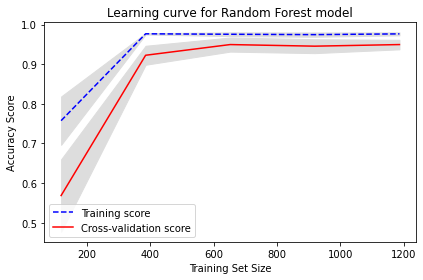

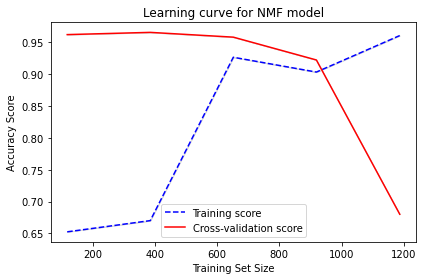

In [57]:
# Plot learning curves
plot_learning_curve(train_sizes, train_scores, test_scores,'Learning curve for Random Forest model')
plot_learning_curve(train_sizes, train_scores_nmf, test_scores_nmf,'Learning curve for NMF model')

#### Conclusion

Looking at two learning curve plots above, we observe that:  

+ The Random forest model: the larger training set size, the higher accuracy score, especially, when training size is over 400, the accuracy score is improved close to below 100% and stable. So, I think in this case, the more data we have, the higher accuracy score we get.   

+ The NMF model: is very different from Random Forest model, in overall, when training set size increases, accuracy score increases, especially, when training set size is around 600, the accuracy score is improved a lot, it is over around 92%. However, when using less than 600 articles for training, the accuracy score is unstable, it is so slow when training size is less than 400 and then increases close to 90% when training size is around 600. So, increasing the size of the dataset may help increase the accuracy of this NMF model, but the maximum accuracy might not reach 100%.
 